In [1]:
%matplotlib inline
import numpy as np 
import nglview as nv
from falass import readwrite, job, sld, reflect, compare

# ISIS Neutron Training Course
## MD-based analysis of neutron reflectometry

#### Andrew R. McCluskey 
##### University of Bath/Diamond Light Source - arm61@bath.ac.uk

2018-03-08

In this exercise, you will learn to analyse a neutron reflectometry dataset using a molecular dynamics (MD) simulation. The aim of this exercise is to understand how reflectometry experiments can be analysed using MD, this notebook details how falass [1] can be used to determine neutron reflectometry from a simulation trajectory. API documentation for falass is available at https://readthedocs.org/projects/falass/.

The first thing to do with falass is to read in some experimental data, there is an example data set and simulation in the `example` directory. This can be read using the following python command:

```
readwrite.Files(datfile='filepath')
```

So to read the example dataset we run the following. 

In [2]:
files = readwrite.Files(datfile='example/example.dat')

These .dat files are three column space separated files consisting of information about q, reflected intensity and an uncertainty in reflected intensity.

In [3]:
cat example/example.dat

0.051793 0.00034985 5.0354e-06
0.054383 0.00031165 4.2426e-06
0.057102 0.00028761 3.6729e-06
0.059957 0.00024688 3.0832e-06
0.062955 0.00021509 2.6625e-06
0.066103 0.00019243 2.3042e-06
0.069408 0.00016831 2.0471e-06
0.072878 0.00014882 1.8137e-06
0.076522 0.00013023 1.5953e-06
0.080348 0.00010985 1.413e-06
0.084365 9.301e-05 1.233e-06
0.088584 7.9305e-05 1.0706e-06
0.093013 6.7076e-05 9.3772e-07
0.097664 5.8056e-05 8.355e-07
0.10255 4.7308e-05 7.2453e-07
0.10767 3.983e-05 6.4247e-07
0.11306 3.2151e-05 5.6431e-07
0.11871 2.7395e-05 5.1552e-07
0.12465 2.1987e-05 4.4466e-07
0.13088 1.8585e-05 4.0611e-07
0.13742 1.4942e-05 3.7729e-07
0.14429 1.1456e-05 3.3753e-07
0.15151 9.3753e-06 3.1949e-07
0.15908 6.2979e-06 2.7863e-07
0.16704 5.5088e-06 1.6133e-06
0.17539 4.2825e-06 1.2664e-06
0.18416 3.4385e-06 1.012e-06
0.19337 2.6153e-06 3.151e-07
0.20304 2.2895e-06 5.691e-07
0.21319 1.6778e-06 1.264e-07
0.22385 1.5736e-06 1.999e-07
0.23504 1.7357e-06 3.884e-07
0.24679 1.7277e-06 5.944e-07
0.25913 

The above command simply defines the datfile in the files class, these now must be read into computer memory.

In [4]:
files.read_dat()

Reading DAT file 

[ 0 % ]
[# 10 % ]
[## 20 % ]
[### 30 % ]
[#### 40 % ]
[##### 50 % ]
[###### 60 % ]
[####### 70 % ]
[######## 80 % ]
[######### 90 % ]
[########## 100 % ]


We can also plot this data to check that the right file has been read in. 

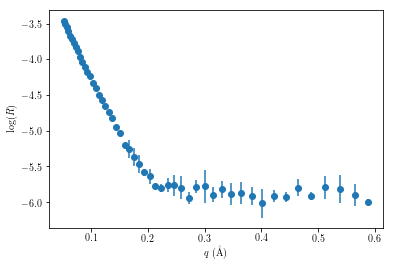

In [5]:
expdata = files.plot_dat(rq4=False)
expdata.show()

With the experimental data, it is then necessary to get an associated simulation. Since we are simulated a monolayer, it is best to create a monolayer-like starting structure. This has been done for you, using the software packmol and the 'make_mono.inp' script, this will be demonstrated by the lecturer. This results in a monolayer of very low surface coverage.

In [6]:
mono_init = pt.load('example/monolayer.pdb')
view = nv.show_pytraj(mono_init)
view

A Jupyter Widget

Now it is necessary to solvate the structure -- technically this could be achieved with packmol, however in order to get the structure shown below a more involved method using GROMACS utilities was used (if you are intereseted speak to the lecturer). You can view this structure using VMD (using nglview will likely crash the computer due to the size). 

This is a suitable starting structure for our simulations. Now we must find an accurate force-field, luckly as we are studying a lipid system many force-fields exist (as the study of lipids are important to the rationalisation of membrane proteins, amoung other systems). A great resource for lipid force-fields is the [lipidbook](https://lipidbook.bioch.ox.ac.uk/), this is a public repository for force-field parameters for lipids that is curated by the lipid biophysics group at Oxford University. Visit this website and try and find a suitable set of parameters, note we will be performing the simulations using GROMACS. 

You will quickly note that no parameters exist on this site for DSPC, however there are parameters for DPPC. This lipid is very similar to DSPC (just has two fewer carbons in each chain). This means that we can do a common computationalist practice of edited the force-field parameters to apply it to our model. Download the DPPC parameters and consider how they could be edited to be applied to DSPC. To save you effort or actually changing the force-field files (a non-trivial task) we have included the modified files (dspc.top), try comparing the two sets of parameters. 

Now that we have a starting structure and a set of force-field parameters it is possible to perform the simulation. In the data directory, you will find two .mdp files; namely squeeze.mdp and equil.mdp. The former allows for the performance of an in-silico Langmuir trough, where the pressure is greater in the x- and y-dimensions than it is the in z-dimension. 

The way that simulations are set up is dependent on the program used. For GROMACS the syntax is:

```
gmx grompp -f settings.mdp -o output.tpr -c structure.pdb -p force.top
```

This will produce a .tpr file that for which the simulation can be run using, 

```
gmx mdrun -deffnm -v output
```

Since these simulations take a long time to run. There are a pair of completed simulations in the data file, named low_apm.pdb and high_apm.pdb. These can be viewed with VMD. 

It is now necessary to read this simulation file into falass.

In [7]:
files.pdbfile = 'example/example.pdb'
files.flip = True
files.read_pdb()

Reading PDB file 

[ 0 % ]
[# 10 % ]
[## 20 % ]
[### 30 % ]
[#### 40 % ]
[##### 50 % ]
[###### 60 % ]
[####### 70 % ]
[######## 80 % ]
[######### 90 % ]
[########## 100 % ]


With the trajectory read in we must give scattering lengths to each of the different atom types. This is achieved through a .lgt file. 

In [8]:
cat example/example.lgt

C1 26.659000000000002 0.0
C2 26.659000000000002 0.0
C3 26.659000000000002 0.0
N4 9.36 0.0
C5 19.998 0.0
C6 19.998 0.0
O7 5.803000000000001 0.0
P8 5.13 0.0
O9 5.803000000000001 0.0
O10 5.803000000000001 0.0
O11 5.803000000000001 0.0
C12 19.998 0.0
C13 13.317 0.0
O14 5.803000000000001 0.0
C15 6.646000000000001 0.0
O16 5.803000000000001 0.0
C17 19.998 0.0
C18 19.998 0.0
C19 19.998 0.0
C20 19.998 0.0
C21 19.998 0.0
C22 19.998 0.0
C23 19.998 0.0
C24 19.998 0.0
C25 19.998 0.0
C26 19.998 0.0
C27 19.998 0.0
C28 19.998 0.0
C29 19.998 0.0
C30 19.998 0.0
C31 19.998 0.0
C32 19.998 0.0
C33 26.659000000000002 0.0
C34 19.998 0.0
O35 5.803000000000001 0.0
C36 6.646000000000001 0.0
O37 5.803000000000001 0.0
C38 19.998 0.0
C39 19.998 0.0
C40 19.998 0.0
C41 19.998 0.0
C42 19.998 0.0
C43 19.998 0.0
C44 19.998 0.0
C45 19.998 0.0
C46 19.998 0.0
C47 19.998 0.0
C48 19.998 0.0
C49 19.998 0.0
C50 19.998 0.0
C51 19.998 0.0
C52 19.998 0.0
C53 19.998 0.0
C54 26.659000000000002 0.0
OW 0.0 0.0
HW1 0.0 0.0
HW2 0.0 0.

In [9]:
files.lgtfile = 'example/example.lgt'
files.read_lgt()

Reading LGT file 

[ 0 % ]
[# 10 % ]
[## 20 % ]
[### 30 % ]
[#### 40 % ]
[##### 50 % ]
[###### 60 % ]
[####### 70 % ]
[######## 80 % ]
[######### 90 % ]
[########## 100 % ]


These three files are brought together in the Job object and the scattering lengths are assigned to the different atom types. 

In [10]:
layer_thickness = 1.
cut_off = 5.

job = job.Job(files, layer_thickness, cut_off)
job.set_lgts()

Setting atoms lengths 

[ 0 % ]
[# 10 % ]
[### 30 % ]
[##### 50 % ]
[###### 60 % ]
[######## 80 % ]
[########## 100 % ]


It is then possible to determine the scattering length denisty profiles as follows. 

Calculating SLD profile
[ 0 % ]
[# 10 % ]
[## 20 % ]
[### 30 % ]
[#### 40 % ]
[##### 50 % ]
[###### 60 % ]
[####### 70 % ]
[######## 80 % ]
[######### 90 % ]
[########## 100 % ]
Getting average SLD profile
[ 0 % ]
[# 10 % ]
[## 20 % ]
[### 30 % ]
[#### 40 % ]
[##### 50 % ]
[###### 60 % ]
[####### 70 % ]
[######## 80 % ]
[######### 90 % ]
[########## 100 % ]


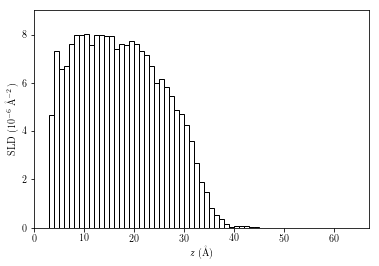

<module 'matplotlib.pyplot' from '/home/arm61/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [11]:
sld = sld.SLD(job)
sld.get_sld_profile()
sld.average_sld_profile()
sld.plot_sld_profile()

This scattering length density profile is then converted to a reflectometry profile as follows.

Calculating reflectometry
[ 0 % ]
[# 10 % ]
[### 30 % ]
[##### 50 % ]
[###### 60 % ]
[######## 80 % ]
[########## 100 % ]


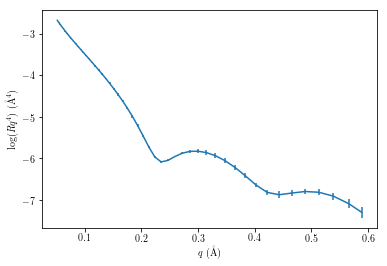

<module 'matplotlib.pyplot' from '/home/arm61/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [12]:
reflect = reflect.Reflect(sld.sld_profile, files.expdata)
reflect.calc_ref()
reflect.average_ref() 
reflect.plot_ref(rq4=False)

Finally the experimental data can be compared with the data arising from simulation. 

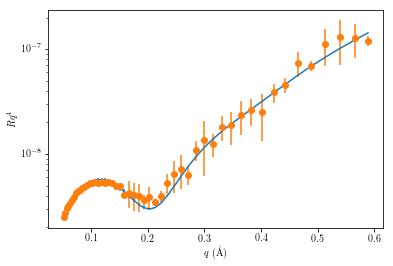

<module 'matplotlib.pyplot' from '/home/arm61/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [13]:
compare = compare.Compare(files.expdata, reflect.averagereflect, 1e-1, 1e-6)
compare.fit()
compare.return_fitted()
compare.plot_compare()

Now open a new notebook and analyse the high_apm.pdb and low_apm.pdb trajectories for each of the following contrasts:

- d$_{83}$-DSPC in ACMW
- d$_{70}$-DSPC in ACMW
- d$_{83}$-DSPC in D$_2$O
- d$_{70}$-DSPC in D$_2$O
- h-DSPC in D$_2$O

All of the datasets, the simulation trajectories and some of the lgtfiles are found in the `data` directory. Determine which trajectory better represents the experimental system under study. Once you have found the correct simulation discuss how the use of simulation-based analysis methods could improve the data obtained from reflectometry experiments. 

[1] *falass*, Andrew R. McCluskey, (http://people.bath.ac.uk/arm61/falass/)